In [1]:
%matplotlib notebook

import os, sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import database
from snowballing.operations import reload, work_by_varname, load_work_map_all_years
from snowballing.strategies import Strategy, State
import custom_strategies
from functools import reduce
from matplotlib_venn import venn2, venn2_circles
from matplotlib import pyplot as plt
import pandas as pd

custom_strategies.LIMIT_YEAR = 2015
reload()
# !pip install matplotlib-venn

In [2]:
from snowballing.operations import metakey, metakey_title

def busca(*libraries, seed=None, filter_function=None):
    filter_function = filter_function or (lambda x: x.category in ("snowball",))
    if seed is not None:
        iterable = ((1, work_by_varname(x)) for x in seed)
    else:
        iterable = load_work_map_all_years()
    seedset = set()
    visited = set()
    for _, work in iterable:
        for library in libraries:
            if int(getattr(work, library, 0)):
                visited.add(work)
                if filter_function(work):
                    seedset.add(work)
                break
    return seedset, filter_function, visited

def descreve_delta(strategy, state, name):
    target = state.find(name)
    previous_related = reduce(lambda x, y: x | y, (s.related for s in target.previous[0]), set())
    for work in previous_related:
        backward = set(strategy.ref[work]) & target.delta_visited
        if backward:
            print('backward', work.metakey)
            for ref in backward:
                print('-', ref.metakey, 'related' if ref in target.delta_related else '')
        forward = set(strategy.rev_ref[work]) & target.delta_visited
        if forward:
            print('forward', work.metakey)
            for ref in forward:
                print('-', ref.metakey, 'related' if ref in target.delta_related else '')

def separa_backward_forward(state):
    backward = set()
    forward = set()
    stack = [state]
    visited = {id(state)}
    while stack:
        current = stack.pop()
        if current.previous:
            if current.previous[1] == "backward":
                backward |= current.delta_related
            if current.previous[1] == "forward":
                forward |= current.delta_related
                
            antecessors = current.previous[0]
            for previous in antecessors:
                if id(previous) not in visited:
                    visited.add(id(previous))
                    stack.append(previous)
    return backward, forward

def encontraria(strategy, state):
    backward = set()
    forward = set()
    related = state.related - state.find("s0").related
    for work in state.related:
        backward |= (set(strategy.ref[work]) & related)
        forward |= (set(strategy.rev_ref[work]) & related)
    return backward, forward

#busca("scopus", seed=["wohlin2014a", "briand2000a"], filter_function=lambda x: True)
#busca("scopus", filter_function=lambda x: False)

# Estratégias

## Estratégia 1 - Busca em todas Digital Libraries (DL)

In [3]:
print ("Total de estudos primários usados como Seed Set: ", len ({x for _, x in load_work_map_all_years() if x.category == "snowball"}))


Total de estudos primários usados como Seed Set:  51


In [4]:
print ("Lista de estudos primários usados como Seed Set:")
({x for _, x in load_work_map_all_years() if x.category == "snowball"})

Lista de estudos primários usados como Seed Set:


{Application of GQM+ Strategies{	extregistered} in the Japanese space industry,
 A conceptual framework for SPI evaluation,
 Defining and monitoring strategically aligned software improvement goals,
 Experiences and insights from applying gqm+ strategies in a systems product development organisation,
 A Cynefin based approach to process model tailoring and goal alignment,
 Linking software development and business strategy through measurement,
 The Rosetta Stone Methodology - A benefits-driven approach to SPI,
 Entropy based software processes improvement,
 Which Processes Are Needed in Five Years? Strategic Process Portfolio Management at the Japan Aerospace Exploration Agency (JAXA),
 An approach to support the strategic alignment of software process improvement programs,
 Business-oriented software process improvement based on CMM using QFD,
 Application of GQM+ Strategies in a small software development unit,
 GQM+ Strategies: A comprehensive methodology for aligning business strat

In [5]:
reload()
TOTAL = {x for _, x in load_work_map_all_years() if (x.category == "snowball")}
filter_function = lambda x: x.category in ("snowball", "forward", "backward")
print (len (TOTAL))


51


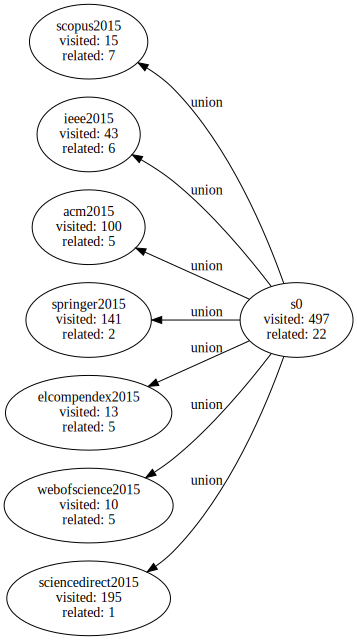

In [6]:
from snowballing.strategies import State

reload()
def busca_completa(libs, filter_function):
    union = None
    for dl in libs:
        strategy = Strategy(*busca(dl, filter_function=filter_function))
        strategy.initial.name = dl
        if union is None:
            union = strategy.initial.derive("union", name="s0")
        else:
            union.visited.update(strategy.initial.visited)
            union.related.update(strategy.initial.related)
            union.previous[0].append(strategy.initial)

    State.last_id = 0
    strategy.initial = union
    return strategy

strategy = busca_completa(["scopus2015", "ieee2015", "acm2015", "springer2015", "elcompendex2015", "webofscience2015", "sciencedirect2015"], filter_function)
#strategy.initial.find("acm")
strategy.initial



In [7]:
array = []

print ("--- Estratégia 1 (E1) ---")
name = "E1"
EP = (len (strategy.initial.related) / len (strategy.initial.visited))*100
print ("Precision: " + "%.1f" %EP +"%")
ER = (len (strategy.initial.related) / len (TOTAL))*100
print ("Recall: " + "%.1f" %ER +"%")
FS = 2*((EP*ER)/(EP+ER))
print ("F-Measure: " + "%.1f" %FS +"%")

array.append((name, EP, ER, FS))

--- Estratégia 1 (E1) ---
Precision: 4.4%
Recall: 43.1%
F-Measure: 8.0%


## Estratégia 2 - Busca em todas Digital Libraries + Snowballing (Guideline - sfbu)

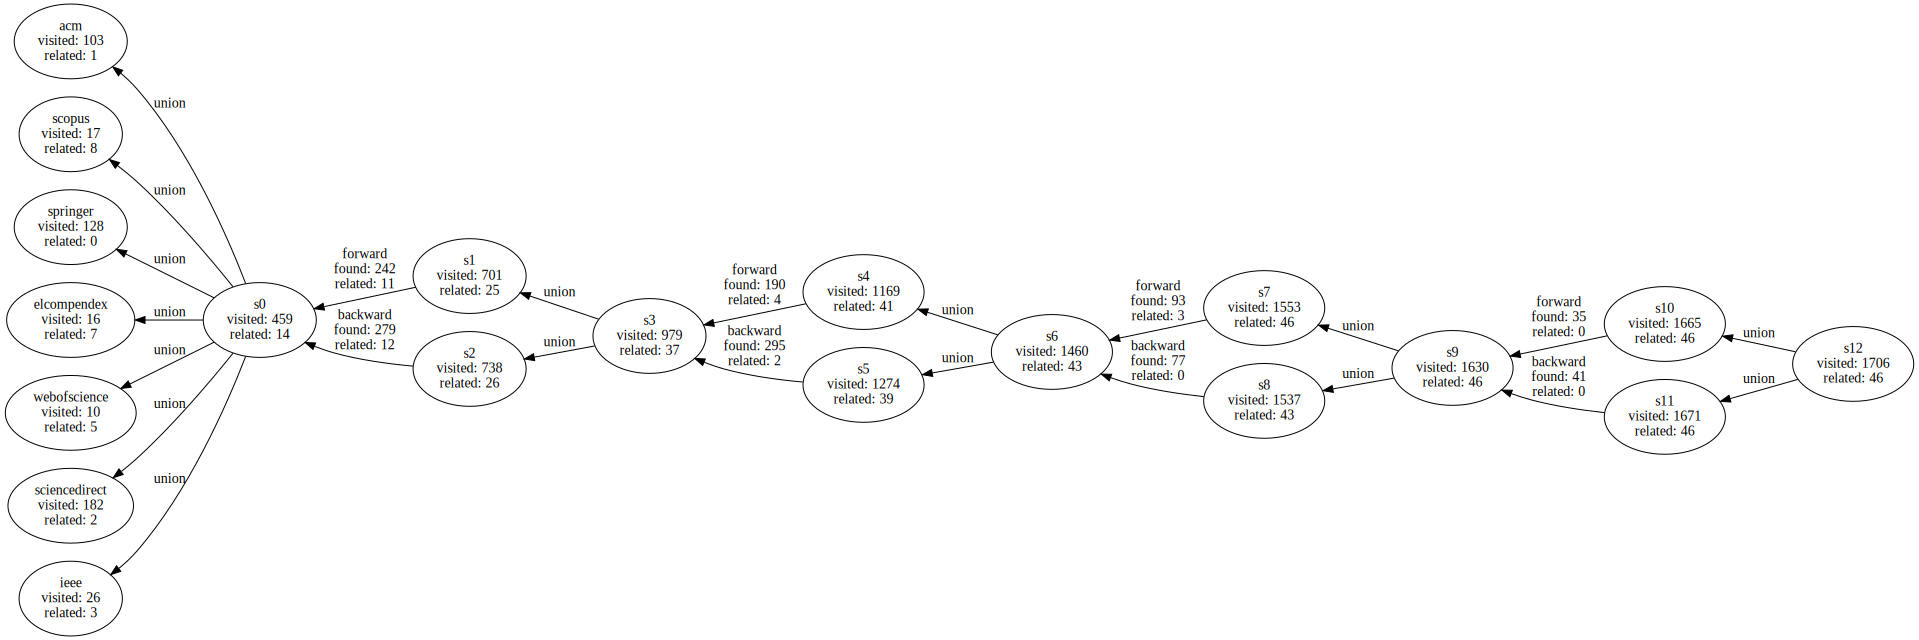

In [8]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = busca_completa(["acm", "scopus", "springer", "elcompendex", "webofscience", "sciencedirect", "ieee"], filter_function)
#Strategy(*busca("acm","scopus", filter_function=filter_function))

state = strategy.sfbu()
#state = strategy.bbff()
#state = strategy.ffbb()
#state = strategy.s2ffbb2u()

state

In [9]:
def duplicados(strategy, state):
    encontrados = set()
    result = set()
    soma = 0
    related = state.related - state.find("s0").related
    for work in state.related:
        inter = encontrados & (set(strategy.ref[work]) & related)
        if inter:
            soma += len(inter)
            encontrados |= inter
            print(work @ metakey, "backward", inter @ metakey)
        inter = encontrados & (set(strategy.rev_ref[work]) & related)
        if inter:
            soma += len(inter)
            encontrados |= inter
            print(work @ metakey, "forward", inter @ metakey)
    return soma

<IPython.core.display.Javascript object>


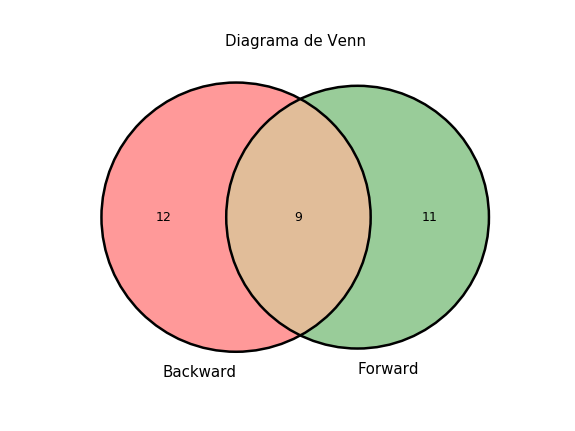

In [10]:
sets = separa_backward_forward(state)
sets = encontraria(strategy, state)
v = venn2(sets, set_labels = ('Backward', 'Forward'))
c = venn2_circles(sets)
plt.title('Diagrama de Venn')
plt.show()

In [11]:
#Backward - Execução de backward em sets[0]
print("Backward", sets[0] @ metakey)
print("Forward", sets[1] @ metakey)

Backward ['trienekens2009a', 'münch2013c', 'liu2006a', 'basili2007c', 'kowalczyk2010a', 'martins2007b', 'mandić2010d', 'liu2005a', 'armbrust2010a', 'basili2007a', 'mandić2010a', 'münch2013a', 'messnarz1999a', 'hinley1995a', 'mcloughlin2010a', 'murugappan2003a', 'debou2000a', 'becker2008b', 'trendowicz2011a', 'basili2007b', 'mccoy1998a']
Forward ['mcloughlin2010b', 'unterkalmsteiner2014a', 'münch2013c', 'armbrust2010b', 'cocozza2014a', 'karlström2002a', 'kowalczyk2010a', 'mandić2010d', 'trienekens2004a', 'wang2005a', 'stallinger2013a', 'armbrust2010a', 'birkhölzer2011a', 'mandić2010a', 'münch2013a', 'petersen2015a', 'trendowicz2014a', 'mcloughlin2010a', 'becker2008b', 'trendowicz2011a']


In [12]:
strategy.initial is state.find("s0")

True

In [13]:
E2P = (len (strategy.initial.related) / len (strategy.initial.visited))*100

print ("--Precision--")
print ("Busca: %.1f%%" % E2P)

E2PS = (len(state.related - state.find("s0").related) / len(state.visited - state.find("s0").visited))*100

print ("Snowballing: %.2f%%" % E2PS)

print("- Forward - iteração 1: %.2f%%" % ((len (state.find("s1").delta_related) / len (state.find("s1").delta_visited))*100))

print("- Backward - iteração 1: %.2f%%" % ((len (state.find("s2").delta_related) / len (state.find("s2").delta_visited))*100))

print("Precision E2 (Busca + Snowballing): %.1f%%" % ((len(state.related) / len(state.visited))*100))


print ("\n--- Estratégia 2 (E2) ---")
name = "E2"
EP = (len (state.related) / len (state.visited))*100
print ("Precision: " + "%.1f" %EP +"%")
ER = (len (state.related) / len (TOTAL))*100
print ("Recall: " + "%.1f" %ER +"%")
FS = 2*((EP*ER)/(EP+ER))
print ("F-Measure: " + "%.1f" %FS +"%")

array.append((name, EP, ER, FS))

--Precision--
Busca: 3.1%
Snowballing: 2.57%
- Forward - iteração 1: 4.55%
- Backward - iteração 1: 4.30%
Precision E2 (Busca + Snowballing): 2.7%

--- Estratégia 2 (E2) ---
Precision: 2.7%
Recall: 90.2%
F-Measure: 5.2%


In [14]:
from collections import deque
def precision_recall(state, total, stop=""):
    # Precisao 0 quando nao visita nada
    array = [[
        "state", "precision", "recall", "operation", 
        "related", "visited", "delta_related", "delta_visited",
        "accumulated_precision", "accumulated_recall",
    ]]
    stack = deque([state])
    visited = {id(state)}
    while stack:
        current = stack.pop()
        try:
            accumulated_precision = len(current.related) / len(current.visited)
            precision = len(current.delta_related) / len(current.delta_visited)
        except ZeroDivisionError:
            precision = 0.0
            
        array.append([
            current.name,
            precision,
            len(current.delta_related) / len(total),
            current.previous[1] if current.previous else "-",
            len(current.related),
            len(current.visited),
            len(current.delta_related),
            len(current.delta_visited),
            accumulated_precision,
            len(current.related) / len(total),
        ])
        if current.name == stop:
            break
        if current.previous:              
            antecessors = current.previous[0]
            for previous in antecessors:
                if id(previous) not in visited:
                    visited.add(id(previous))
                    stack.appendleft(previous)
    return array

In [15]:
df = pd.DataFrame(list(reversed(precision_recall(state, TOTAL))))
df.columns = df.iloc[-1]
df = df.drop(df.index[-1])
df

20,state,precision,recall,operation,related,visited,delta_related,delta_visited,accumulated_precision,accumulated_recall
0,ieee,0.115385,0.0588235,-,3,26,3,26,0.115385,0.0588235
1,sciencedirect,0.010989,0.0392157,-,2,182,2,182,0.010989,0.0392157
2,webofscience,0.5,0.0980392,-,5,10,5,10,0.5,0.0980392
3,elcompendex,0.4375,0.137255,-,7,16,7,16,0.4375,0.137255
4,springer,0,0,-,0,128,0,128,0,0
5,scopus,0.470588,0.156863,-,8,17,8,17,0.470588,0.156863
6,acm,0.00970874,0.0196078,-,1,103,1,103,0.00970874,0.0196078
7,s0,0,0,union,14,459,0,0,0.0305011,0.27451
8,s2,0.0430108,0.235294,backward,26,738,12,279,0.0352304,0.509804
9,s1,0.0454545,0.215686,forward,25,701,11,242,0.0356633,0.490196


<IPython.core.display.Javascript object>


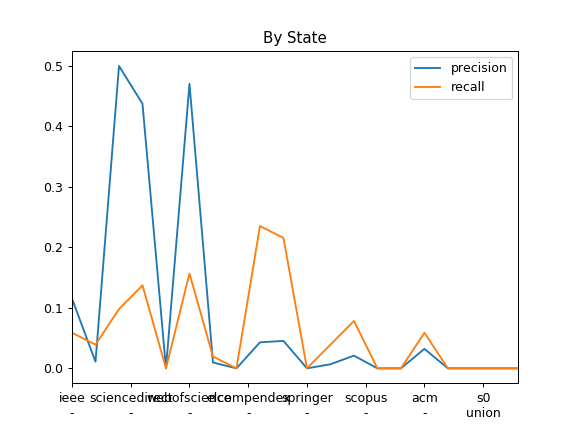

In [16]:
fig = plt.figure()
df['precision'].plot(legend=True)
df['recall'].plot(legend=True)
ax = plt.gca()
ax.set_xticklabels(df["state"] + "\n" + df["operation"])
ax.set_title("By State");

<IPython.core.display.Javascript object>


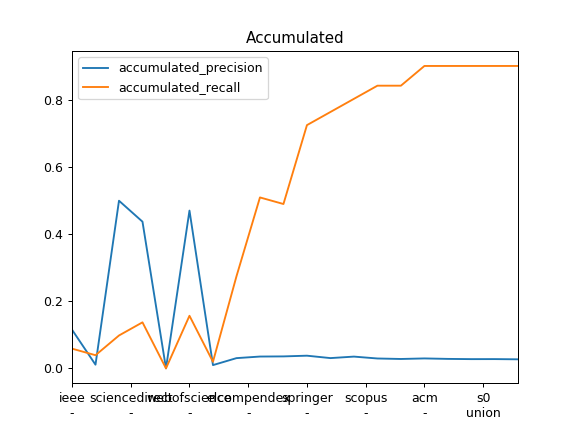

In [17]:
fig = plt.figure()
df['accumulated_precision'].plot(legend=True)
df['accumulated_recall'].plot(legend=True)
ax = plt.gca()
ax.set_xticklabels(df["state"] + "\n" + df["operation"])
ax.set_title("Accumulated");

## Estratégia 3 - Busca Informal (Google Scholar) + Snowballing (Guideline - sfbu)

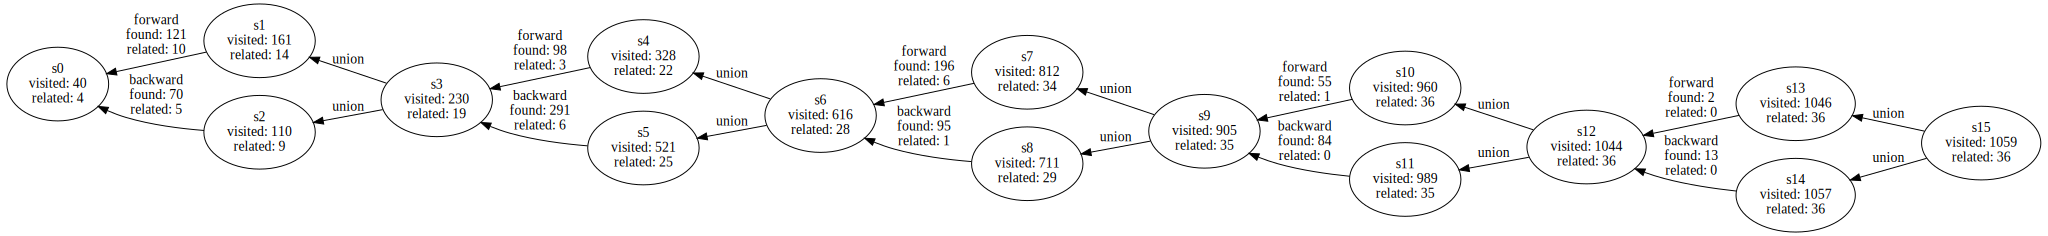

In [18]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("gs", filter_function=filter_function))
state = strategy.sfbu()
state

In [19]:
print ("--- Estratégia 3 (E3) ---")
name = "E3"
EP = (len (state.related) / len (state.visited))*100
print ("Precision: " + "%.1f" %EP +"%")
ER = (len (state.related) / len (TOTAL))*100
print ("Recall: " + "%.1f" %ER +"%")
FS = 2*((EP*ER)/(EP+ER))
print ("F-Measure: " + "%.1f" %FS +"%")

array.append((name, EP, ER, FS))

--- Estratégia 3 (E3) ---
Precision: 3.4%
Recall: 70.6%
F-Measure: 6.5%



## Estratégia 4 - Busca em Scopus + Snowballing (Guideline - sfbu)

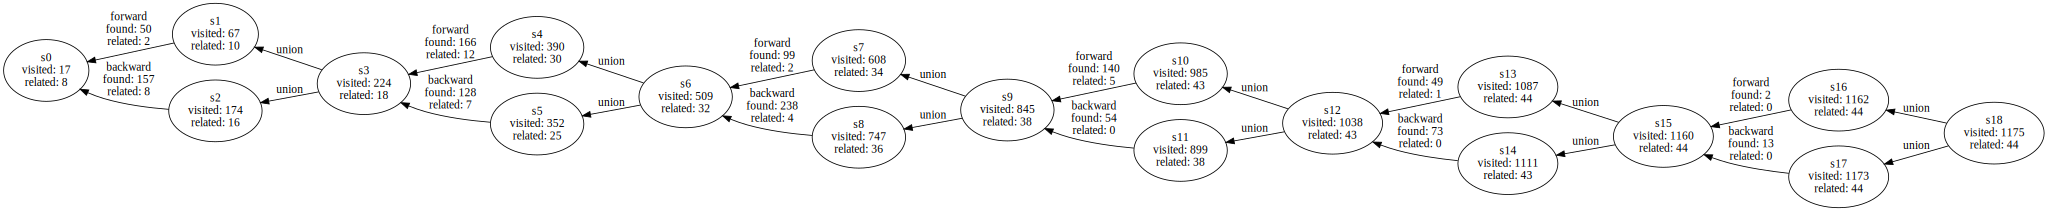

In [20]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus", filter_function=filter_function))

#from copy import copy
#strategy.initial.visited = copy(strategy.initial.related)
state = strategy.sfbu()
state

In [21]:
print ("--- Estratégia 4 (E4) ---")
name = "E4"
EP = (len (state.related) / len (state.visited))*100
print ("Precision: " + "%.1f" %EP +"%")
ER = (len (state.related) / len (TOTAL))*100
print ("Recall: " + "%.1f" %ER +"%")
FS = 2*((EP*ER)/(EP+ER))
print ("F-Measure: " + "%.1f" %FS +"%")

array.append((name, EP, ER, FS))

--- Estratégia 4 (E4) ---
Precision: 3.7%
Recall: 86.3%
F-Measure: 7.2%


## Estratégia 5 - Busca em Scopus + Snowballing (Short Paper - s2ffbb2u)

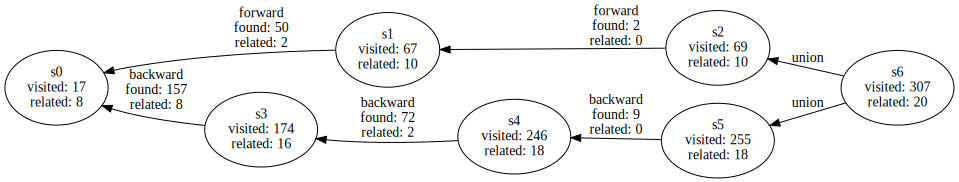

In [22]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus", filter_function=filter_function))
state = strategy.s2bbff2u()
state

In [23]:
print ("--- Estratégia 5 (E5) ---")
name = "E5"
EP = (len (state.related) / len (state.visited))*100
print ("Precision: " + "%.1f" %EP +"%")
ER = (len (state.related) / len (TOTAL))*100
print ("Recall: " + "%.1f" %ER +"%")
FS = 2*((EP*ER)/(EP+ER))
print ("F-Measure: " + "%.1f" %FS +"%")

array.append((name, EP, ER, FS))

--- Estratégia 5 (E5) ---
Precision: 6.5%
Recall: 39.2%
F-Measure: 11.2%


## Estratégia 6 - Busca em Scopus + Snowballing (JF - bbff)

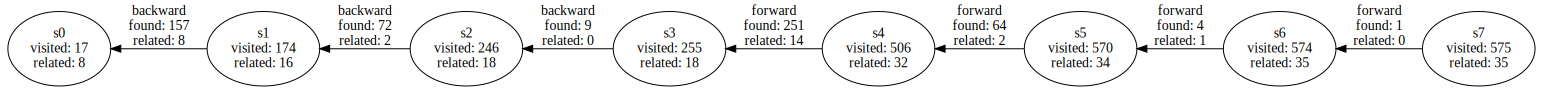

In [24]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus", filter_function=filter_function))
state = strategy.bbff()
state

In [ ]:
print ("--- Estratégia 6 (E6) ---")
name = "E6"
EP = (len (state.related) / len (state.visited))*100
print ("Precision: " + "%.1f" %EP +"%")
ER = (len (state.related) / len (TOTAL))*100
print ("Recall: " + "%.1f" %ER +"%")
FS = 2*((EP*ER)/(EP+ER))
print ("F-Measure: " + "%.1f" %FS +"%")

array.append((name, EP, ER, FS))

## Estratégia 7 - Busca em Scopus + Snowballing (JF - ffbb)

In [ ]:
reload()
filter_function = lambda x: x.category in ("snowball", "forward", "backward")

strategy = Strategy(*busca("scopus", filter_function=filter_function))
state = strategy.ffbb()
state

In [ ]:
print ("--- Estratégia 7 (E7) ---")
name = "E7"
EP = (len (state.related) / len (state.visited))*100
print ("Precision: " + "%.1f" %EP +"%")
ER = (len (state.related) / len (TOTAL))*100
print ("Recall: " + "%.1f" %ER +"%")
FS = 2*((EP*ER)/(EP+ER))
print ("F-Measure: " + "%.1f" %FS +"%")

array.append((name, EP, ER, FS))

# Análise das Estratégias

In [ ]:
%matplotlib notebook
import pandas as pd

In [ ]:
df = pd.DataFrame (array,columns = ['Estratégia','Precision','Recall','F-Measure'])
df.index = df['Estratégia']
df


In [ ]:
import matplotlib.pyplot as plt
ax = df.plot.bar(title ="Precision e Recall das Estratégias")
plt.tight_layout()


In [ ]:
df